In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
dataset=r"C:\Users\gaura\OneDrive\Documents\DTU\Year 2\Semester 1\Modelling and Simulation\Mask_Dataset"
imagePaths=list(paths.list_images(dataset))


data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [5]:
data[0]

array([[[-0.94509804, -0.9764706 , -0.85882354],
        [-0.94509804, -0.9764706 , -0.85882354],
        [-0.94509804, -0.9764706 , -0.85882354],
        ...,
        [-0.8509804 , -0.90588236, -0.78039217],
        [-0.8509804 , -0.90588236, -0.78039217],
        [-0.84313726, -0.8980392 , -0.77254903]],

       [[-0.9137255 , -0.94509804, -0.827451  ],
        [-0.9137255 , -0.94509804, -0.827451  ],
        [-0.9137255 , -0.94509804, -0.827451  ],
        ...,
        [-0.7490196 , -0.8039216 , -0.6784314 ],
        [-0.7490196 , -0.8039216 , -0.6784314 ],
        [-0.7411765 , -0.79607844, -0.67058825]],

       [[-0.92156863, -0.9607843 , -0.8039216 ],
        [-0.92156863, -0.9529412 , -0.81960785],
        [-0.92156863, -0.9607843 , -0.8039216 ],
        ...,
        [-0.88235295, -0.8980392 , -0.7882353 ],
        [-0.85882354, -0.8901961 , -0.77254903],
        [-0.85882354, -0.8745098 , -0.7647059 ]],

       ...,

       [[ 0.38823533, -0.9607843 , -0.36470586],
        [ 0

In [6]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [7]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [8]:
dev_X,test_X,dev_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [9]:
train_X, valid_X, train_Y, valid_Y = train_test_split(dev_X,dev_Y,test_size=0.125, random_state=10)

In [10]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [11]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

print(baseModel.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

In [13]:
model=Model(inputs=baseModel.input,outputs=headModel)

In [14]:
for layer in baseModel.layers:
    layer.trainable=False

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
learning_rate=0.001
Epochs=20
BS=12

In [16]:
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(valid_X,valid_Y),
    validation_steps=len(valid_X)//BS,
    epochs=Epochs
)

c:\users\gaura\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
80/80 [==============================] - 45s 520ms/step - loss: 0.1984 - accuracy: 0.9295 - val_loss: 0.0364 - val_accuracy: 0.9855
Epoch 2/20
80/80 [==============================] - 39s 491ms/step - loss: 0.0875 - accuracy: 0.9674 - val_loss: 0.0211 - val_accuracy: 0.9928
Epoch 3/20
80/80 [==============================] - 39s 482ms/step - loss: 0.0454 - accuracy: 0.9842 - val_loss: 0.0150 - val_accuracy: 0.9928
Epoch 4/20
80/80 [==============================] - 42s 518ms/step - loss: 0.0351 - accuracy: 0.9884 - val_loss: 0.0198 - val_accuracy: 0.9855
Epoch 5/20
80/80 [==============================] - 39s 492ms/step - loss: 0.0390 - accuracy: 0.9905 - val_loss: 0.0277 - val_accuracy: 0.9855
Epoch 6/20
80/80 [==============================] - 40s 498ms/step - loss: 0.0318 - accuracy: 0.9895 - val_loss: 0.0203 - val_accuracy: 0.9855
Epoch 7/20
80/80 [==============================] - 41s 506ms/step - loss: 0.0272 - accuracy: 0.9926 - val_loss: 0.0208 - val_accuracy: 0.9928

In [17]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



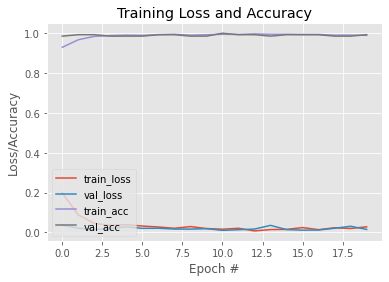

In [18]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")